# CSE 152: Intro to Computer Vision - Spring 2019 Assignment 4
## Instructor: David Kriegman
### Assignment published on Wednesday, May 29, 2019
### Due on Friday, June 7, 2019 at 11:59pm

## Instructions
* This assignment must be completed individually. Review the academic integrity and collaboration policies on the course website.
* All solutions should be written in this notebook. Show your work for written questions.
* If you want to modify the skeleton code, you may do so. It has been merely been provided as a framework for your solution.
* You may use Python packages for basic linear algebra (e.g. NumPy or SciPy for basic operations), but you may not use packages that directly solve the problem. If you are unsure about using a specific package or function, ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as an `.ipynb` file. Submit both files (`.pdf` and `.ipynb`) on Gradescope. **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy:** a penalty of 10% per day after the due date.

---

## Problem 1: Machine Learning [10 pts]

In this problem, you will implement K-Nearest Neighbors (KNN) algorithm for computer vision problems.

### Part 1: Data preparation [1 pts]

Download the MNIST data from http://yann.lecun.com/exdb/mnist/.

Download the 4 zipped files, extract them into one folder, and change the variable 'path' in the code below. (Code taken from https://gist.github.com/akesling/5358964 )

Plot one random example image corresponding to each label from the training data.

In [5]:
import os
import struct
import numpy as np

# Change path as required
path = "./mnist_data/"

def read(dataset="training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainLabels=np.array(list(read('training','labels')))
testData=np.array(list(read('testing','images')))
testLabels=np.array(list(read('testing','labels')))

Some helper functions are given below.

Random classifier accuracy: 10.160000 

Plot random training images for each class:


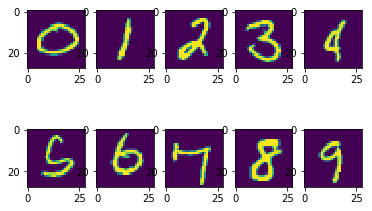

In [7]:
# a generator for batches of data
# yields data (batchsize, 3, 32, 32) and labels (batchsize)
# if shuffle, it will load batches in a random order
import matplotlib.pyplot as plt
def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

# a sample classifier
# given an input it outputs a random class
class RandomClassifier():
    def __init__(self, classes=10):
        self.classes=classes
    def __call__(self, x):
        return np.random.randint(self.classes, size=x.shape[0])

randomClassifier = RandomClassifier()
print('Random classifier accuracy: %f \n' % 
      test(testData, testLabels, randomClassifier))

print('Plot random training images for each class:')
count = 0
check = np.zeros(10)
imgs = np.zeros((10, 28, 28))
for img, lb in DataBatch(trainData, trainLabels, 1, shuffle=True):
    img = np.squeeze(img)
    if check[lb] == 1:
        continue
    else:
        check[lb] += 1
        count += 1
        imgs[lb,:,:] = img
    if count == 10:
        break

fig, ax = plt.subplots(nrows=2, ncols=5)
i = 0
for row in ax:
    for col in row:
        col.imshow(imgs[i,:,:])
        i += 1

plt.show()

### Part 2: Confusion Matrix [3 pts]
Here you will implement a function that computes the confusion matrix for a classifier.
The matrix (M) should be nxn where n is the number of classes.
Entry M[i,j] should contain the fraction of images of class i that were classified as class j.

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3586.13it/s]


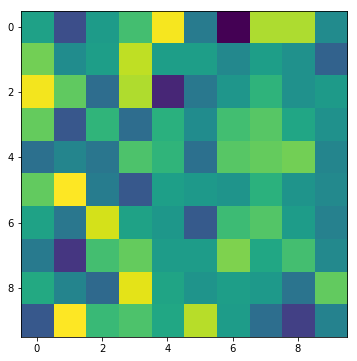

[[0.1  0.08 0.1  0.11 0.12 0.09 0.07 0.11 0.11 0.1 ]
 [0.11 0.1  0.1  0.12 0.1  0.1  0.1  0.1  0.1  0.09]
 [0.12 0.11 0.09 0.11 0.08 0.09 0.1  0.1  0.1  0.1 ]
 [0.11 0.09 0.1  0.09 0.1  0.1  0.11 0.11 0.1  0.1 ]
 [0.09 0.09 0.09 0.11 0.1  0.09 0.11 0.11 0.11 0.09]
 [0.11 0.12 0.09 0.09 0.1  0.1  0.1  0.1  0.1  0.1 ]
 [0.1  0.09 0.12 0.1  0.1  0.09 0.11 0.11 0.1  0.09]
 [0.09 0.08 0.11 0.11 0.1  0.1  0.11 0.1  0.11 0.1 ]
 [0.1  0.09 0.09 0.12 0.1  0.1  0.1  0.1  0.09 0.11]
 [0.09 0.12 0.11 0.11 0.1  0.11 0.1  0.09 0.08 0.09]]


In [8]:
# Using the tqdm module to visualize run time is suggested
from tqdm import tqdm
import time

# It would be a good idea to return the accuracy, along with the confusion 
# matrix, since both can be calculated in one iteration over test data, to 
# save time
def Confusion(testData, testLabels, classifier):
    '''
    Your code here
    '''
    M = np.zeros((10,10))
    
    '''for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            batchsize = 50
            correct = 0
            incorrect = 0
            for data, label in tqdm(DataBatch(testData,testLabels,batchsize,shuffle = False),
                                   total = len(testData)// batchsize):
                correct += np.sum(label == i)
                prediction = classifier(data)
                incorrect += np.sum((prediction == j)&(label == i))
                M[i][j] = incorrect/correct
    accuracy = test(testData, testLabels, classifier)     '''   #too slow    
    batchsize = 50
    correct = 0
    acc = 0
    for data, label in tqdm(DataBatch(testData,testLabels,batchsize,shuffle = False),total = len(testData)// batchsize):
        predic = classifier(data)
        for i in range(len(predic)):
            M[label[i],predic[i]] += 1
            if(label[i] == predic[i]):
                acc += 1
    for i in range(M.shape[0]):
        M[i] = M[i]/np.sum(M[i])
    
    accuracy = acc * 100/len(testData)
    return M, accuracy

def VisualizeConfusion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,2))
    
M, _ = Confusion(testData, testLabels, randomClassifier)
VisualizeConfusion(M)

### Part 3: K-Nearest Neighbors (KNN) [6 pts]

* Here you will implement a simple knn classifier. The distance metric is Euclidean in pixel space. k refers to the number of neighbors involved in voting on the class, and should be 3. You are allowed to use sklearn.neighbors.KNeighborsClassifier.
* Display the confusion matrix and accuracy for your KNN classifier trained on the entire training dataset. (should be ~97%)
* After evaluating the classifier on the test set, based on the confusion matrix, mention the number that the number '4' is most often predicted to be, other than '4'. Write your comment below.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
class KNNClassifer():
    def __init__(self, k=3):
        # k is the number of neighbors involved in voting
        '''
        your code here
        '''
        self.k = k
        self.classifier = KNeighborsClassifier(self.k)
        
    def train(self, trainData, trainLabels):
        '''
        your code here
        '''
        traindata = trainData.reshape((trainData.shape[0],-1))
        self.classifier.fit(traindata, trainLabels) 
        
    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        '''
        your code here
        '''
        testdata = x.reshape(x.shape[0],-1)
        return self.classifier.predict(testdata)
    
# test your classifier with only the first 100 training examples (use this
# while debugging)
# note you should get ~ 65 % accuracy
knnClassiferX = KNNClassifer()
knnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassiferX))

KNN classifier accuracy: 64.760000


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [15:19<00:00,  4.55s/it]


accuracy: 97.05%


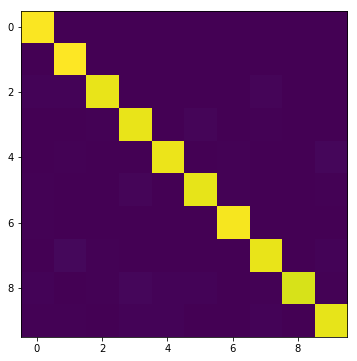

[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.01 0.97 0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.97 0.   0.01 0.   0.01 0.   0.  ]
 [0.   0.01 0.   0.   0.97 0.   0.   0.   0.   0.02]
 [0.01 0.   0.   0.01 0.   0.96 0.01 0.   0.   0.  ]
 [0.01 0.   0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.02 0.   0.   0.   0.   0.   0.96 0.   0.01]
 [0.01 0.   0.   0.02 0.01 0.01 0.   0.   0.94 0.  ]
 [0.   0.   0.   0.01 0.01 0.   0.   0.01 0.   0.96]]


In [6]:
# test your classifier trained with all the training examples (This may take a while)
knnClassifer = KNNClassifer()
knnClassifer.train(trainData, trainLabels)

# display confusion matrix and testing accuracy for your KNN classifier trained with all the training examples
'''
your code here
'''
M, acc = Confusion(testData, testLabels, knnClassifer)
print('accuracy: {}%'.format(acc))
VisualizeConfusion(M)


### Comment:

* The number that '4' is most often predicted to be other than '4' is '9'. Beacause M[i,j] should contain the fraction of images of class i that were classified as class j. The second maximum in row 4 is 0.02 and it's in column 9. 

## Problem 2: Deep Learning [18 pts]

### Part 1: Initial setup [0 pts]

Follow the directions on https://pytorch.org/get-started/locally/ to install PyTorch on your computer.

Note: You will not need GPU support for this assignment so don't worry if you don't have one. In any case, installing with GPU support is often more difficult to configure, so it is suggested that you install the CPU-only version regardless.

To ensure that PyTorch was installed correctly, we will now verify the installation by running some sample PyTorch code. Here we construct a randomly initialized tensor.

In [5]:
from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.2075, 0.2549, 0.8538],
        [0.7507, 0.0028, 0.9274],
        [0.9450, 0.8472, 0.2955],
        [0.9411, 0.6834, 0.2007],
        [0.4453, 0.5391, 0.0604]])


### Part 2:  Training with PyTorch [3 pts]
Below is some helper code to train your deep networks. 
Complete the train function for PTClassifier below. You should write down the training operations in this function. This function will be used in the following questions with different networks.
You can look at https://pytorch.org/tutorials/beginner/pytorch_with_examples.html for reference.

In [9]:
# base class for your PyTorch networks. It implements the training loop
# (__init__), (train) and prediction(__call__)  for you.
# You will need to complete the (train) function to define the training operations
# structures in the following problems.
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.init
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from scipy.stats import truncnorm

class PTClassifier():
    def __init__(self, net):
        self.net = net()
    
    def train(self, trainData, trainLabels, testData, testLabels, epochs=1, batchsize=50):
        criterion = nn.CrossEntropyLoss()
        learning_rate=3e-4
        optimizer = optim.Adam(self.net.parameters(),lr=learning_rate)
        for epoch in range(epochs):
            for i, (data,label) in enumerate(DataBatch(trainData, trainLabels, batchsize, shuffle=True)):
                inputs = Variable(torch.FloatTensor(data))
                targets = Variable(torch.LongTensor(label))

                # YOUR CODE HERE
                # Train the model using the optimizer and the batch data
                optimizer.zero_grad()
                
                outputs = self.net(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

            print ('Epoch:%d Accuracy: %f'%(epoch+1, test(testData, testLabels, self)))
        
        
        
    def __call__(self, x):
        inputs = Variable(torch.FloatTensor(x))
        prediction = self.net(inputs)
        return np.argmax(prediction.data.cpu().numpy(), 1)
    
    def get_first_layer_weights(self):
        return self.net.weight1.data.cpu().numpy()

# helper function to get weight variable
def weight_variable(shape):
    initial = torch.Tensor(truncnorm.rvs(-1/0.01, 1/0.01, scale=0.01, size=shape))
    return Parameter(initial, requires_grad=True)

# helper function to get bias variable
def bias_variable(shape):
    initial = torch.Tensor(np.ones(shape)*0.1)
    return Parameter(initial, requires_grad=True)
    
# Define Single Layer Perceptron network
class SLP(nn.Module):
    def __init__(self, in_features=28*28, classes=10):
        super(SLP, self).__init__()
        # model variables
        self.weight1 = weight_variable((classes, in_features))
        self.bias1 = bias_variable((classes))
        
    def forward(self, x):
        # linear operation
        y_pred = torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weight1.t())
        return y_pred
        

# test the example linear classifier (note you should get around 92% accuracy
# for 10 epochs and batchsize 50)
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
trainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
testData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))

linearClassifier = PTClassifier(SLP)
linearClassifier.train(trainData, trainLabels, testData, testLabels, epochs=10)
print ('Linear classifier accuracy: %f'%test(testData, testLabels, linearClassifier))

Epoch:1 Accuracy: 89.200000
Epoch:2 Accuracy: 90.770000
Epoch:3 Accuracy: 91.260000
Epoch:4 Accuracy: 91.640000
Epoch:5 Accuracy: 91.800000
Epoch:6 Accuracy: 92.040000
Epoch:7 Accuracy: 92.240000
Epoch:8 Accuracy: 92.220000
Epoch:9 Accuracy: 92.340000
Epoch:10 Accuracy: 92.370000
Linear classifier accuracy: 92.370000


### Part 3: Single Layer Perceptron [3 pts]
The simple linear classifier implemented in the cell already performs quite well. Plot the filter weights corresponding to each output class (weights, not biases) as images. (Normalize weights to lie between 0 and 1 and use color maps like 'inferno' or 'plasma' for good results). Comment on what the weights look like and why that may be so.


Epoch:1 Accuracy: 89.250000
Epoch:2 Accuracy: 90.770000
Epoch:3 Accuracy: 91.380000
Epoch:4 Accuracy: 91.600000
Epoch:5 Accuracy: 91.870000
Epoch:6 Accuracy: 91.930000
Epoch:7 Accuracy: 92.250000
Epoch:8 Accuracy: 92.250000
Epoch:9 Accuracy: 92.260000
Epoch:10 Accuracy: 92.330000


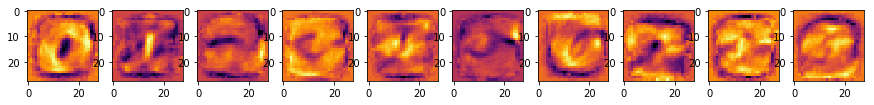

In [9]:
# Your code here.
linearClassifier = PTClassifier(SLP)
linearClassifier.train(trainData, trainLabels, testData, testLabels, epochs=10)

w = linearClassifier.get_first_layer_weights()
plt.figure(figsize = (15,15))
for i in range(10):
    im = w[i,:]
    im = np.reshape(im,(28,28))
    im -= np.min(im)
    im /= np.max(im)
    plt.subplot(1,10,i+1)
    plt.imshow(im,cmap = 'inferno')
plt.show()

### Comment

* We can figure out which number the weight figure represents to. For example, the first image is similar to zero. Because SLP is a linear model, the weights corresponding numbers have greater values than background.

### Part 4: Multi Layer Perceptron (MLP) [7 pts]
Here you will implement an MLP. The MLP shoud consist of 2 layers (matrix multiplication and bias offset) that map to the following feature dimensions:

* 28x28 -> hidden (100)
* hidden -> classes

* The hidden layer should be followed with a ReLU nonlinearity. The final layer should not have a nonlinearity applied as we desire the raw logits output.
* The final output of the computation graph should be stored in self.y as that will be used in the training.

Display the confusion matrix and accuracy after training. Note: You should get around 97% accuracy for 10 epochs and batch size 50.

Plot the filter weights corresponding to the mapping from the inputs to the first 10 hidden layer outputs (out of 100). Do the weights look similar to the weights plotted in the previous problem? Why or why not?

In [10]:
# Define Multi Layer Perceptron network
class MLP(nn.Module):
    def __init__(self, in_features=28*28, hidden=100, classes=10):
        super(MLP, self).__init__()
        '''
        your code here
        '''
        self.weight1 = weight_variable((hidden, in_features))
        self.bias1 = bias_variable((hidden))
        
        self.weight2 = weight_variable((classes, hidden))
        self.bias2 = bias_variable((classes))
        
        
    def forward(self, x):
        '''
        your code here
        '''
        result1 = torch.relu(torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weight1.t()))
        y_pred = torch.addmm(self.bias2, result1.view(list(result1.size())[0], -1), self.weight2.t())
        return y_pred         


mlpClassifer = PTClassifier(MLP)
mlpClassifer.train(trainData, trainLabels, testData, testLabels, epochs=10)

Epoch:1 Accuracy: 91.160000
Epoch:2 Accuracy: 93.010000
Epoch:3 Accuracy: 93.930000
Epoch:4 Accuracy: 94.710000
Epoch:5 Accuracy: 95.320000
Epoch:6 Accuracy: 95.820000
Epoch:7 Accuracy: 96.150000
Epoch:8 Accuracy: 96.500000
Epoch:9 Accuracy: 96.770000
Epoch:10 Accuracy: 96.670000


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1215.38it/s]


accuracy: 96.67%


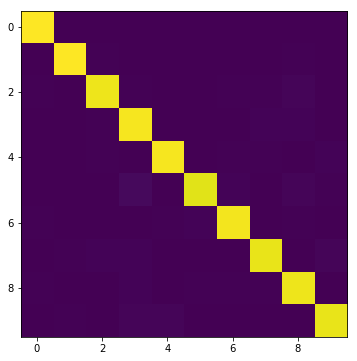

[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.98 0.   0.   0.   0.   0.   0.   0.01 0.  ]
 [0.01 0.   0.96 0.01 0.   0.   0.   0.01 0.01 0.  ]
 [0.   0.   0.   0.97 0.   0.   0.   0.01 0.01 0.  ]
 [0.   0.   0.   0.   0.97 0.   0.01 0.   0.   0.01]
 [0.   0.   0.   0.02 0.   0.94 0.01 0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.   0.01 0.97 0.   0.01 0.  ]
 [0.   0.01 0.01 0.01 0.   0.   0.   0.96 0.   0.01]
 [0.   0.   0.   0.01 0.   0.   0.   0.01 0.96 0.  ]
 [0.   0.01 0.   0.01 0.01 0.   0.   0.   0.   0.95]]


In [11]:
# Confusion Matrix and Accuracy
'''
your code here
'''
M, acc = Confusion(testData, testLabels, mlpClassifer)
print('accuracy: {}%'.format(acc))
VisualizeConfusion(M)

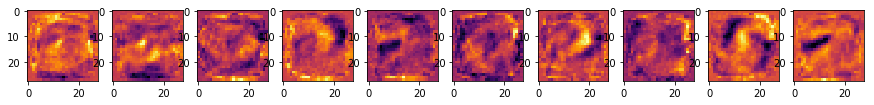

In [13]:
# plot filter weights
'''
your code here
'''

w = linearClassifier.get_first_layer_weights()
plt.figure(figsize = (15,15))
for i in range(10):
    im = w[i,:]
    im = np.reshape(im,(28,28))
    im -= np.min(im)
    im /= np.max(im)
    plt.subplot(1,10,i+1)
    plt.imshow(im,cmap = 'inferno')
plt.show()


### Comment

* The weights images of MLP is less likely to be numbers than that of SLP. Because MLP is non-linear, The purpose of the multiple layers is to classify rather than display a number.

### Part 5: Convolutional Neural Network (CNN) [5 pts]
Here you will implement a CNN with the following architecture:

* n=5
* ReLU( Conv(kernel_size=4x4, stride=2, output_features=n) )
* ReLU( Conv(kernel_size=4x4, stride=2, output_features=n*2) )
* ReLU( Conv(kernel_size=4x4, stride=2, output_features=n*4) )
* Linear(output_features=classes)

Display the confusion matrix and accuracy after training. You should get around 98% accuracy for 10 epochs and batch size 50.

In [10]:
def conv2d(x, W, stride):
    # x: input
    # W: weights (out, in, kH, kW)
    return F.conv2d(x, W, stride=stride, padding=1)

# Define Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, classes=10, n=5):
        super(CNN, self).__init__()
        '''
        your code here
        '''
        '''self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 1,out_channels = n,kernel_size = 4,stride = 2,padding = 1),
                                  nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels = n,out_channels = 2*n,kernel_size = 4,stride = 2,padding = 1),
                                  nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels = 2*n,out_channels = 4*n,kernel_size = 4,stride = 2,padding = 1),
                                  nn.ReLU())
        
        self.fc1 = nn.Linear(100,50)
        self.fc2 = nn.Linear(50,10)'''
        
        self.weight1 = weight_variable((n,1,4,4))
        self.bias1 = bias_variable((n,1,1))
        
        self.weight2 = weight_variable((n*2,n,4,4))
        self.bias2 = bias_variable((n*2,1,1))        
        
        self.weight3 = weight_variable((n*4,n*2,4,4))
        self.bias3 = bias_variable((n*4,1,1))
        
        self.weight4 = weight_variable((180,90))
        self.bias4 = bias_variable((90))
        j7
        self.weight5 = weight_variable((90,classes))
        self.bias5 = bias_variable((classes))
       
    def forward(self, x):
        '''
        your code here
        '''
        
        x = torch.reshape(x,[50,1,28,28])
        result1 = torch.relu(conv2d(x, self.weight1, stride = 2) + self.bias1)
        result2 = torch.relu(conv2d(result1, self.weight2, stride = 2) + self.bias2)
        result3 = torch.relu(conv2d(result2, self.weight3, stride = 2) + self.bias3)
        y_pred = torch.addmm(self.bias4,result3.view(list(result3.size())[0], -1), self.weight4)
        y_pred = torch.addmm(self.bias5,y_pred.view(list(y_pred.size())[0], -1), self.weight5)
        return y_pred
    
    
cnnClassifer = PTClassifier(CNN)
cnnClassifer.train(trainData, trainLabels, testData, testLabels, epochs=10)

Epoch:1 Accuracy: 85.660000
Epoch:2 Accuracy: 90.180000
Epoch:3 Accuracy: 91.870000
Epoch:4 Accuracy: 93.210000
Epoch:5 Accuracy: 93.350000
Epoch:6 Accuracy: 95.120000
Epoch:7 Accuracy: 95.640000
Epoch:8 Accuracy: 95.930000
Epoch:9 Accuracy: 96.490000
Epoch:10 Accuracy: 96.860000


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 279.30it/s]


accuracy: 97.71%


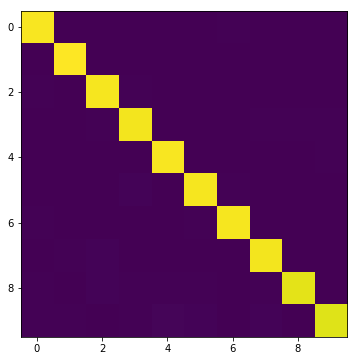

[[0.99 0.   0.   0.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.98 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.98 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.01 0.   0.98 0.   0.   0.   0.  ]
 [0.01 0.   0.   0.   0.   0.01 0.98 0.   0.   0.  ]
 [0.   0.01 0.01 0.   0.   0.   0.   0.98 0.   0.  ]
 [0.01 0.   0.01 0.01 0.   0.01 0.   0.01 0.95 0.  ]
 [0.   0.01 0.   0.   0.01 0.01 0.   0.01 0.   0.95]]


In [15]:
# Confusion Matrix and Accuracy
'''
your code here
'''
M, acc = Confusion(testData, testLabels, cnnClassifer)
print('accuracy: {}%'.format(acc))
VisualizeConfusion(M)

* Note that the MLP/ConvNet approaches lead to an accuracy a little higher than the K-NN approach. 
* In general, neural net approaches lead to a significant increase in accuracy, but in this case the problem is not too hard, so the increase in accuracy will not be very high.
* However, this is still quite significant considering the fact that the ConvNets we've used are relatively simple while the accuracy achieved using K-NN is with a search over 60,000 training images for every test image.
* You can look at the performance of various machine learning methods on this problem at http://yann.lecun.com/exdb/mnist/
* You can learn more about PyTorch at https://pytorch.org/tutorials/index.html
* You can find another image classifier training example at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
* You can play with a demo of neural network created by Daniel Smilkov and Shan Carter at https://playground.tensorflow.org/